 <div style="text-align: right">Sachin Umans</div>
 <div style="text-align: right">March 2025</div>

 # Crash course for the control uninitiated for Systeem & Regeltechniek


In [39]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
plt.rcParams.update({ 'text.usetex':        False,              'mathtext.fontset':         'cm',
                      'font.size':          12.0,               'axes.labelsize':           'medium',
                      'xtick.labelsize':    'x-small',          'ytick.labelsize':          'x-small',
                      'axes.grid':          True,               'axes.formatter.limits':    [-3, 6],
                      'grid.alpha':         0.5,                'figure.figsize':           [11.0, 4],
                      'figure.constrained_layout.use': True,    'scatter.marker':           'x',
                      'savefig.dpi':        300,                'savefig.bbox':             'tight',
                      'savefig.pad_inches': 0.05,               'savefig.transparent':      True})

from IPython.display import display, Markdown, HTML

import warnings
warnings.filterwarnings("ignore")

import scipy.signal as signal
import scipy.linalg as sclin
import numpy.random as rng
import numpy.linalg as lin
import control as cm
from helperFunctions import *

 # Time domain
 ## Systems and differential equations
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*The basics of all things control*

 *Systems are all and all is a system.* So you can decribe dynamic processses with physics, then you get equations with time derivatives. So for Linear-Time-Independent (LTI) systems, the differential equation with output $y(t)$ and input $u(t)$ is
 $$ \frac{d^n}{d^nt}y + a_1\frac{d^{n-1}}{d^{n-1}t}y + \cdots + a_n y = \frac{d^m}{d^mt}u + b_1\frac{d^{m-1}}{d^{m-1}t}u + \cdots + b_m u.$$
 Here, $n$ is called the order of the system.

 We want to be able to solve Initial Value Problems (IVPs), because that's cool and it shows us what the system will do from some initial state. This solution is built in two steps, the homogenous solution and satisfying the initial conditions.

 The homogenous solution is obtained by equation the left hand side to zero. For this, we'll steal a little ahead from the Laplace transform where
 $$ \frac{d^n}{d^nt} \overset{\mathcal{F}}{\rightarrow} s^n. $$
 Applying this and eliminating $y$ to obtain the homogenous solution yields
 $$\frac{d^n}{d^nt}y + a_1\frac{d^{n-1}}{d^{n-1}t}y + \cdots + a_n y = 0 $$
 $$\overset{\mathcal{F},\; \frac{1}{y}}{\rightarrow} s^n + a_1 s^{n-1} + \cdots + a_n = 0. $$
 This is a polynomial of order $n$ called **the characteristic polynomial** and we know then it has $n$ roots as well.

 These roots, $\lambda_k$, actually form the solution to the homogenous problem, since a polynomial is the product of its roots,
 $$ \prod_{k=1}^n (s-\lambda_k).$$
 The solution to these types of ODEs are sums of exponentials of the form $c_k e^{\lambda_k t}$, where $c_k$ is determined through the initial condition. Therefore, the complete solution is
 $$ y(t) = \sum_{k= 1}^n c_k e^{\lambda_k t} .$$

 If all $\mathfrak{R}(\lambda_k) < 0$ then $y(t)$ goes to 0 and the system is stable. The Routh-Hurwitz criterion gives the stability requirements up to the third degree. Stability is guaranteed for systems of order
 1. if $a_1 > 0$.
 2. if $a_1, a_2 > 0$.
 3. if $a_1, a_2, a_3 >0$ and $ a_1a_2 > a_3$.

 Real-valued $\lambda_k$ yield an exponential trajectory $e^{\lambda_k t}$. Complex-values come in conjugate pairs so they yield an exponential trajectory multiplied by a cosine. Because $\lambda_k, \lambda_{k+1} = \epsilon \pm j\omega$, the trajectory of this pair becomes $e^{(\epsilon \pm j\omega)t} = e^{\epsilon t} (e^{j\omega t} + e^{-j\omega t}) = e^{\epsilon t} (2\cos(\omega t))$. Play around with the code block here to get a feel for it!


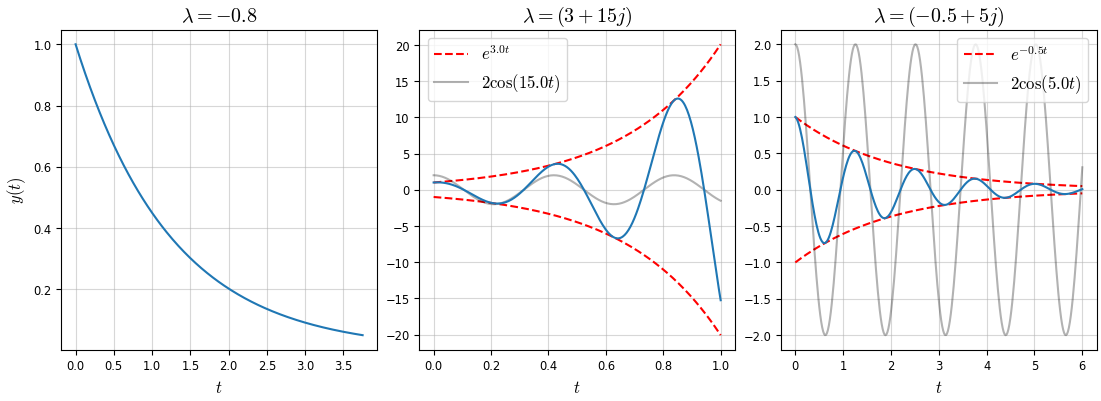

In [40]:
sig1 = -0.8
sig2 = 3 + 15j
sig3 = -0.5 + 5j

###### Processing and Plotting #########
fig, ax = plt.subplots(1,3)
idx = 0
for sig in [sig1, sig2, sig3]:
    t = np.linspace(0, 3/abs(np.real(sig)), num=300)
    if np.iscomplex(sig):
        l1, = ax[idx].plot(t, np.exp(np.real(sig)*t), 'r--', label=f"$e^{r"{"}{sig.real}t{r"}"}$")
        ax[idx].plot(t, -np.exp(np.real(sig)*t), 'r--')
        l2, = ax[idx].plot(t, 2*np.cos(np.imag(sig)*t), 'k', alpha=0.3, label=f"$2\cos({sig.imag} t)$")
        ax[idx].legend(handles=[l1, l2])
    ax[idx].plot(t, np.exp(sig*t))
    ax[idx].set(title=f"$\lambda = {sig}$", xlabel="$t$")
    idx += 1

_ = ax[0].set_ylabel("$y(t)$")

 ## State space representation
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*A blessing from above*

 Cool we know systems now, but it's a bit of an ugly system representation to be honest. Luckily we live in a universe where the state space representation exists and we can recast any system as a vector first order ODE and an output equation. This representation is of the form $$ \dot x = f(x, u)$$ $$ y = h(x, u),$$
 where $x$ is the state of the system, $u$ the input, and $y$ the output. The state dynamics are described with $f: \mathbb{R}^n\times\mathbb{R}^p\rightarrow\mathbb{R}^n$ and the output measurements with $h: \mathbb{R}^n\times\mathbb{R}^p\rightarrow\mathbb{R}^q$.

 What black magic do we perform to get these first order ODEs? Well, suppose you have a second order ODE in $v$, $\ddot v = \dot v + v$, then this is equivalent to the first order ODE $$ \begin{bmatrix}\dot v\\\ddot v\end{bmatrix}  = \begin{bmatrix}0&1\\1&1\end{bmatrix}\begin{bmatrix}\dot v\\ v\end{bmatrix}.$$

 Last but not least of the amazing aspects of the state space representation: there are many nice numerical integrators to simulate them. Think forward Euler or Runge-Kutta.

 <div style="text-align:center;background-color:tomato;">End of lecture 2 (Lecture 1 was course logistics)</div>

 ### Block diagrams
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Pixel perfect ways to visualise systems*

 ![Slide about block diagram elements](BlockDiagEls.png)

 It's a nice sanity check that any fundamental block scheme of an $n$-th order system has $n$ integrators.


 ## Equilibrium points
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Forever and unchanging*

 Often, systems will have equilibria, meaning there are states where system will remain over time. These state-input point pairs are denoted as $(x_e, u_e)$ or $(\bar x, \bar u)$. I'll use the latter since this is more traditional in control and we have to appease our control elders (JW). So equilibria remain unchanging, so the derivative of the state is zero. In mathematicians' language
 $$ \dot{\bar x} = f(\bar x, \bar u) = 0. $$
 Finding the equilibria states as a function of the equilibria inputs is as simple as solving this equation.





 <div style="text-align:center;background-color:tomato;">End of lecture 3</div>

 ## Linearisation
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*The linear life lifts all spirits*

 The general state space representation doesn't have so many assumptions, which is great, however, it's also not very useful for analysis. Now we will assume something that **very** often isn't true, but most of control science is built around this wonderful assumption: *linearity*. There is an easy solution for systems that aren't linear, linearisation and forget anything ever happened!

 Linearisation isn't super difficult: it's just a first order Taylor expansion of $f$ around an equilibrium point. So
 $$f(x,u) \approx f(\bar x, \bar u) + \underbrace{\left.\frac{\partial f(x,u)}{\partial x}\right|_{(\bar x, \bar u)}}_A \underbrace{(x-\bar x)}_x + \underbrace{\left.\frac{\partial f(x,u)}{\partial u}\right|_{(\bar x, \bar u)}}_B \underbrace{(u-\bar u)}_u$$
 $$h(x,u) \approx h(\bar x, \bar u) + \underbrace{\left.\frac{\partial h(x,u)}{\partial x}\right|_{(\bar x, \bar u)}}_C \underbrace{(x-\bar x)}_x + \underbrace{\left.\frac{\partial h(x,u)}{\partial u}\right|_{(\bar x, \bar u)}}_D \underbrace{(u-\bar u)}_u.$$
 If we are extremely intelligent, we can translate $f$ beforehand such that $f(\bar x, \bar u)=0$, perform the underbraced substitutions, and commit some proper notation heresy to end up with the pretties equation of all: *the linear state space*
 $$ \dot x = A x + B u $$
 $$ y = C x + D u .$$

 $\frac{\partial f(x,u)}{\partial x}$ is called the Jacobian of $f$. A nice memory support is to remember that the Jacobian is multiplied with the state from the right such that each state derivative is multiplied with the same state, so the states vary horizontally and the function elements vertically.

 ## Stability
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Most control engineers aren't as stable as their systems*

 If you know epsilon-delta proofs, I'm sorry for your loss. There is an epsilon-delta definition of stability in the slides, have fun. For normal people stability means that a certain system trajectory stays bounded under bounded disturbances. Even simpler: a stable system always returns to certain points. The stability of certain equilibria is easy to assess, since the linearisation is a good approximation locally at the equilibrium point, the stability of the linearised system indicates the stability of the equilibrium point too.

 ### Stability of linear systems
 So assessing the stability of linear systems is important for all types of systems. Before, we already saw some notions of stability in the context of the characteristic polynomial of systems. There are two interesting relations there:
 1. The characteristic polynomial is equivalent to det($sI-A$) for complex $s$.
 2. The roots of the characteristic polynomial are equivalent to the eigenvalues of $A$.

 That second point sounds familiar! We already saw stability related to the roots of the characteristic polynomial before. So, the eigenvalues, $\Lambda$, of $A$ reveal the stability of the system. Surprisingly though, there are three types of stability, not two:
 1. Unstable $\leftarrow \exist\mathfrak{R}(\lambda)>0, \lambda\in\Lambda$.
 2. Neutrally stable $\leftarrow \mathfrak{R}(\lambda)\leq 0, \forall\lambda\in\Lambda$ with at most one eigenvalue at 0 or on conjugate pair with real part 0.
 3. Assymptotically stable $\leftarrow \mathfrak{R}(\lambda)\leq 0, \forall\lambda\in\Lambda$.

 These things are nicely visualised for two dimensional system, so you can guess it: have look at the code block!

Eigenvalues are:
[-0.25+2.2220486j -0.25-2.2220486j]
Eigenvectors are:
[[ 0.91287093+0.j          0.91287093-0.j        ]
 [-0.04564355+0.40568871j -0.04564355-0.40568871j]]


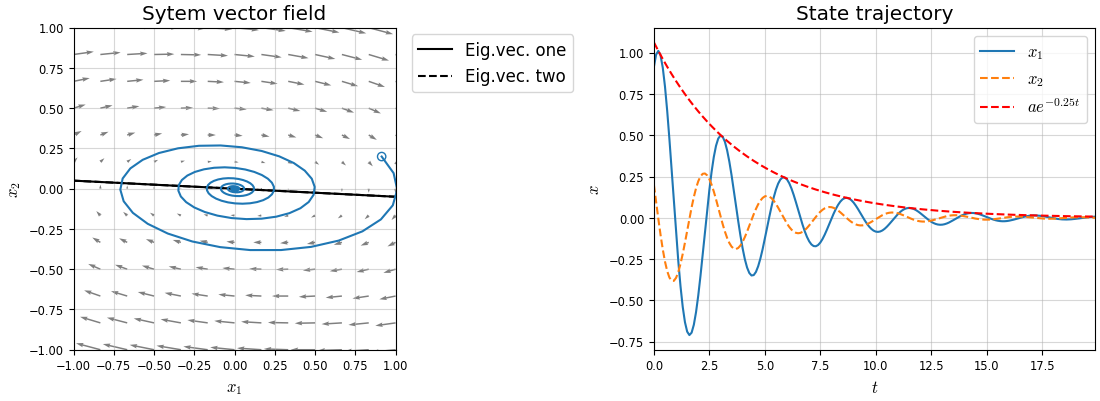

In [41]:
if True: # Toggle between defining A or eigenvalues
    A = np.array([[0, 5],
                [-1, -.5]])
else:
    if 'A' in locals(): del A
    if 'v1' in locals(): del v1, v2

    lambda1 = -1
    lambda2 = -.1

    ## Optionally, you can also define the eigenvectors, otherwise they're random and perpendicular
    # v1 = np.array([[1],[1]])
    # v2 = np.array([[1],[-1]])

###### Processing and Plotting #########
if 'A' not in locals():
    if 'v1' not in locals():
        v1 = rng.randn(2, 1)
        v2 = np.array([[0,-1],[1, 0]])@v1

    T = np.append(v1, v2, axis=1)
    A = T@np.diag([lambda1, lambda2])@lin.inv(T)
    print(f"A is {A}")
else:
    e, v = lin.eig(A)
    print(f"Eigenvalues are:"), print(e)
    print(f"Eigenvectors are:"), print(v)
    v1 = v[:,0][:,np.newaxis]
    v2 = v[:,1][:,np.newaxis]
    lambda1 = e[0]
    lambda2 = e[1]

fig, ax = plt.subplots(1,2)
ax[0].set(aspect="equal", title="Sytem vector field")
vector_field(A=A, v1=v1, v2=v2, ax=ax[0], n=13)

## Create trajectory
traj = np.full([2, 200], np.nan)
traj[:,[0]] = rng.rand(2,1)
h = 0.1
for idx in range(max(traj.shape)-1):
    traj[:, idx+1] = RK4(x=traj[:, idx], dx=lambda x: A@x, h=h)
_ = ax[0].plot(traj[0,:], traj[1,:])
_ = ax[0].scatter(traj[0,0], traj[1,0], marker='o', color='tab:blue', facecolors='none')

T = np.arange(max(traj.shape))*h
l1, = ax[1].plot(T, traj[0,:], label="$x_1$")
l2, = ax[1].plot(T, traj[1,:], '--', label="$x_2$")

if np.iscomplex(lambda1):
    peakIdx, _ = signal.find_peaks(traj[0,:])
    l3, = ax[1].plot(T, traj[0,peakIdx[0]]*np.exp((T-T[peakIdx[0]])*np.real(lambda1)), 'r--', label=f"$a e^{"{"}{np.real(lambda1)}t{"}"}$")
    ax[1].legend(handles=[l1,l2,l3])
else:
    ax[1].legend(handles=[l1,l2])

_ = ax[1].set(xlim=[0, max(T)], title="State trajectory", xlabel="$t$", ylabel="$x$")

 ### How to be an eigenvalue wizard
 Ever had *one of those people* look at a matrix and fully describe its behaviour in a second. Then you check and they're right and you have to take a moment to contemplate if that imposter syndrome might not be as fake as you hoped? Yeah...

 Anyways here are some tricks:
 1. A diagonal matrix has its eigenvalues on the diagonal.
 2. A triangular matrix also has its eigenvalues on the diagonal.
 3. Block diagonal matrices are the union of the eigenvalues of the blocks.
 4. Have a look at the [Jordan normal form](https://en.wikipedia.org/wiki/Jordan_normal_form) if you want, it's also triangular.
 5. The sum of all eigenvalues is the trace of the matrix.
 6. The product of all eigenvalues is the determinant of the matrix.
 7. If $\lambda_k$ are the eigenvalues of $A$, then the eigenvalues of $A^{-1}$ are $1/\lambda_k$.

 ## Coordinate transform
 Sometimes we want to change the coordinate base of our states, either to give them physical meaning or to cast $A$ into a simpler form. This is rather easy linear algebra, lets say the new state $z=Tx \rightarrow x = T^{-1}z$. Then we can substitute that into the state space representation
 $$ \dot x = Ax + Bu \rightarrow T^{-1}\dot z = AT^{-1}z + Bu \rightarrow \dot z = \underbrace{TAT^{-1}}_{\tilde A} z + \underbrace{TB}_{\tilde B}u = \tilde A z + \tilde B u.$$
 and $$ y = Cx + Du \rightarrow y = \underbrace{CT^{-1}}_{\tilde C}z + Du = \tilde C z + Du.$$
 **Important: note that the input/output behaviour remains unchanged under state transformations. This is only a system-internal operation.**

 For $A$ with unique eigenvalues, the system is called diagonalisable, because taking the inverse transformation, $T^{-1}$, to be the horizontally stacked eigenvectors of $A$ results in a diagonal $\tilde A$. Sometimes stuff is named nice and descriptive.

 <div style="text-align:center;background-color:tomato;">End of lecture 4</div>

 ## Textbook input signals
 To generally see how a system output behaves in time, there are two standard signals we like to use:
 1. the Dirac-delta impulse signal
 2. and the (Heaviside) step signal.

 The impulse signal is primarily used to see the transient behaviour of the system and the step functions shows the transient and steady state behaviour. Look at these plots to see! We're even able to seperate the transient from the steady state for the step!

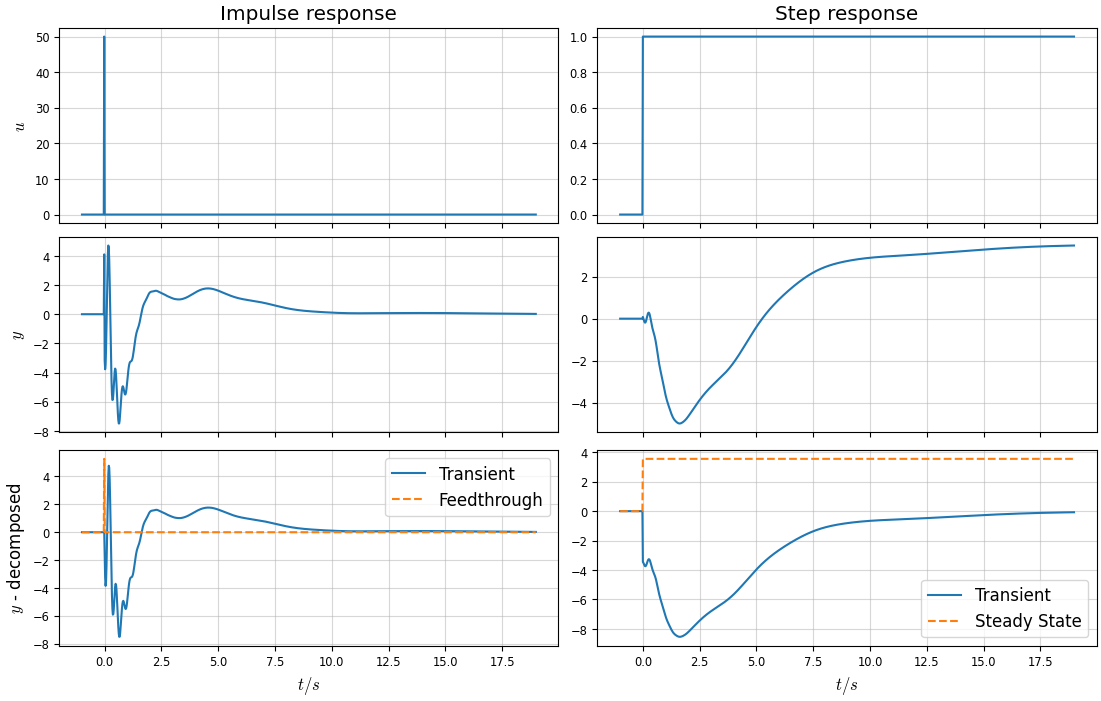

In [42]:
P_res = cm.rss(20)
P_res.D = [rng.rand()]

T_res = np.arange(1000)*0.02 - 1.

## impulse response
impIn = np.zeros_like(T_res)
impIn[int(-T_res[0]/(T_res[1] - T_res[0]))] = 1./0.02
impResponse = cm.forced_response(P_res,
                                 T = T_res,
                                 U = impIn)

impTrans = np.full(len(impResponse.time), np.nan)
impTrans = np.array([(P_res.C@sclin.expm(P_res.A*t)@P_res.B)[0][0] for t in impResponse.time])
impTrans[impResponse.time<0] = 0.0

## step response
stpIn = np.zeros_like(T_res)
stpIn[T_res >= 0] = 1.
stpResponse = cm.forced_response(P_res,
                                 T = T_res,
                                 U = stpIn)

stpTrans = np.zeros_like(T_res)
stpTrans[stpResponse.time >= 0] = np.array([(P_res.C@lin.inv(P_res.A)@sclin.expm(P_res.A*t)@P_res.B)[0][0] 
                        for t in stpResponse.time[stpResponse.time >= 0]])
stpStead = np.zeros_like(T_res)
stpStead[stpResponse.time >= 0] = (P_res.D - P_res.C@lin.inv(P_res.A)@P_res.B)[0][0]

####### Plotting #######
fig, ax = plt.subplots(3,2, sharex='col', figsize=[11, 7])

_ = ax[0,0].set(title="Impulse response", ylabel="$u$")
_ = ax[1,0].set(ylabel="$y$")
_ = ax[2,0].set(xlabel="$t/s$", ylabel="$y$ - decomposed")
_ = ax[0,0].plot(impResponse.time, impResponse.inputs)
_ = ax[1,0].plot(impResponse.time, impResponse.outputs)
l1, = ax[2,0].plot(impResponse.time, impTrans, label="Transient")
l2, = ax[2,0].plot(impResponse.time, np.squeeze(P_res.D*impResponse.inputs), '--', label="Feedthrough")
_ = ax[2,0].legend(handles=[l1,l2])

_ = ax[0,1].set(title="Step response")
_ = ax[2,1].set(xlabel="$t / s$")
_ = ax[0,1].plot(stpResponse.time, stpResponse.inputs)
_ = ax[1,1].plot(stpResponse.time, stpResponse.outputs)
l1, = ax[2,1].plot(stpResponse.time, stpTrans, label="Transient")
l2, = ax[2,1].plot(stpResponse.time, stpStead, '--', label="Steady State")
_ = ax[2,1].legend(handles=[l1,l2])

 Decomposing a signal into a transient and steady state part? How is that possible? It really comes down to seperating the time dependent and time independent parts. By convolution of the input, we can express the state and output trajectory of any LTI system as $$ x(t) = e^{At}x_0 + \int_0^t e^{A(t-\tau)}Bu(\tau)d\tau$$
 and $$ y(t) = Cx(t) + Du(t) = Ce^{At}x_0 + \int_0^t Ce^{A(t-\tau)}Bu(\tau)d\tau + Du(t).$$
 Here, the first term is the effect of the initial condition, the second term is influenced by the input and the third term is the direct feedthrough.

 Now assuming $x_0 =0$, and substituting the respective input time-signals yields the solutions $$ y_\text{impulse}(t) = \underbrace{Ce^{At}B}_\text{Transient} + \underbrace{D\delta(t)}_\text{Feedthrough}$$
 and $$ y_\text{step}(t) = \underbrace{CA^{-1}e^{At}B}_\text{Transient} + \underbrace{D - CA^{-1}B}_\text{Steady State}.$$
 Tada, we've decomposed the signal!

 ## Reachability
 This output trajectory expression answers some interesting questions too: what states are we able to control the system to? This is called the reachability of the system! Remember we have equilibria $(\bar x, \bar u) \leftarrow A\bar x + B\bar u = 0$? Well then if $A$ is invertible this means that $\bar x = -A^{-1}B\bar u$. So, if $A^{-1}B$ is full rank, we can attain any steady state we'd desire!

 This only answers steady state reachability, what can we reach in transient manners though? That's slightly more involved, but not too bad. Lets look back at the expression $$ x(t) = e^{At}x_0 + \int_0^t e^{A(t-\tau)}Bu(\tau)d\tau,$$
 then the interesting part is $\int_0^t e^{A(t-\tau)}Bu(\tau)d\tau = \int_0^t e^{At}Bu(t-\tau)d\tau$ and especially $e^{At}B$, because this factor we can't influence with the input. The term with the initial condition can be compensated for anyways.

 ### Cayley–Hamilton theorem
 Our bestest buddies Cayley and Hamilton came up with a theorem that we need to understand the factor $e^{At}$ better. Quick reminder of how Taylor series  worked (around 0 specifically (also called MacLaurin series if you want to do some barefaced fame stealing)): $$ f(x) = \sum_{k=0}^{\infty}\frac{f^{(k)}(0)}{k!}x^k = \sum_{k=0}^{\infty}\alpha_k(x) f^{(k)}(0).$$
 Also remember how exponential derivatives worked: $$e^{At} \overset{d/dt}{\rightarrow} Ae^{At} \overset{d/dt}{\rightarrow} A^2e^{At} \overset{d/dt}{\rightarrow} A^3e^{At} \overset{d/dt}{\rightarrow} ... \Rightarrow \frac{d^k}{d^kt}e^{At} = A^ke^{At}.$$

 Looks like we're getting somewhere, what if we substitute that derivative expression into the **Taylor** series and recall that $e^{0A}=I$, then $$ e^{At} = \sum_{k=0}^{\infty}\alpha_k(x) A^k.$$
 One step closer still! Now lets right multiply with $B$ and write the summation as a matrix multiplication $$ e^{At}B =  \mathbf{\alpha}(t)\begin{bmatrix}B & AB & A^2B & A^3B & \cdots \end{bmatrix}, \qquad \alpha_k(t)=\frac{t^k}{k!}.$$

 So if $\begin{bmatrix}B & AB & A^2B & A^3B & \cdots \end{bmatrix}$ has full row rank, we can use the input to make $\int_0^t e^{A(t-\tau)}Bu(\tau)d\tau$ anything we want, so we can make $x(t)$ anything we want!! This is the reachability criterion and we actually only have to check the first $n-1$ powers of $A$. This forms the so called reachability matrix (also called controllability matrix), $$ W_r = \begin{bmatrix}B & AB & A^2B & A^3B & \cdots & A^{n-1}B\end{bmatrix}.$$
 So if this $W_r$ of the pair $(A,B)$ is full rank, the system is reachable (or controllable).

 There is also a coordinate transform to something called the reachable canonical form. It's in the slides but not very useful in this explanation.

 <div style="text-align:center;background-color:tomato;">End of lecture 5</div>

 ## Feedback control
 WOW ARE WE GOING TO DO CONTROL NOW??? *FINALLY*???? Yes! No... There's one more difference we need to explain. There are two types of feedback control, output and state feedback. The difference is in the name and here you also see the difference in a block diagram for a plant/process/system, $P$, and a controller, $C$.

 ![output vs state feedback](xyFB.svg)

 Output feedback is stuff like PID, or in other terms: disgusting. We'll look at state feedback now! *The real stuff.*

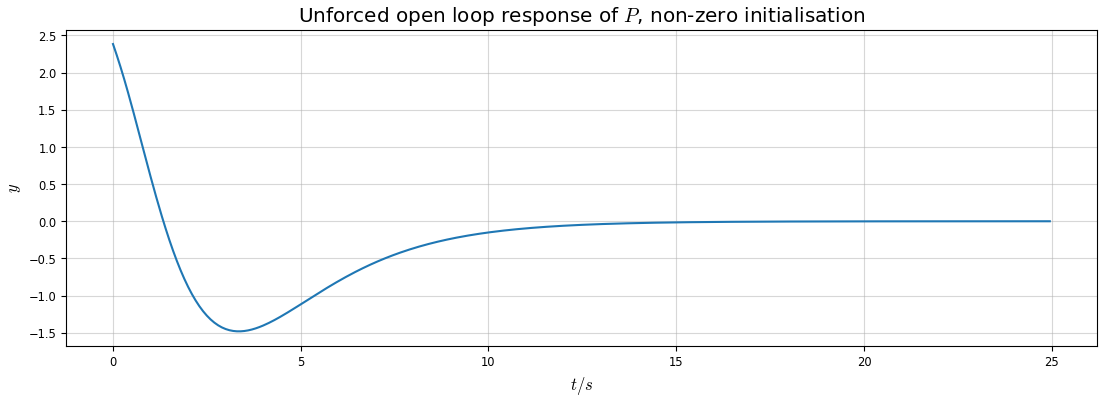

In [43]:
P_reg = cm.ss(cm.zpk(zeros=[-3], 
                     poles=cm.rss(5).poles(), 
                     gain=1, dt=0))
nx_reg = len(P_reg.poles())
x0_reg = rng.randn(nx_reg,1)

T_reg = np.arange(500)*0.05
unforced_reg = cm.forced_response(sysdata=P_reg, 
                              T=T_reg, 
                              X0=x0_reg)

####### Plotting #######
fig, ax = plt.subplots()
ax.plot(unforced_reg.time, unforced_reg.outputs)
_ = ax.set(title="Unforced open loop response of $P$, non-zero initialisation", xlabel="$t/s$", ylabel="$y$")



 We can choose the controller $C: u = -Kx$, and for reachable systems, we can always find a $K$ such that the closed loop system has poles at freely chosen locations. What does that closed loop system look like? Substituting the controller into the state dynamics yields
 $$ \dot x = Ax + Bu = Ax - BKx = (A-BK) x.$$
 So the closed loop system poles are the eigenvalues of $(A-BK)$. If we choose the poles to have a negative real part, the closed loop is stable and the output will go to zero. This type of controller that steers to zero is called a regulator.

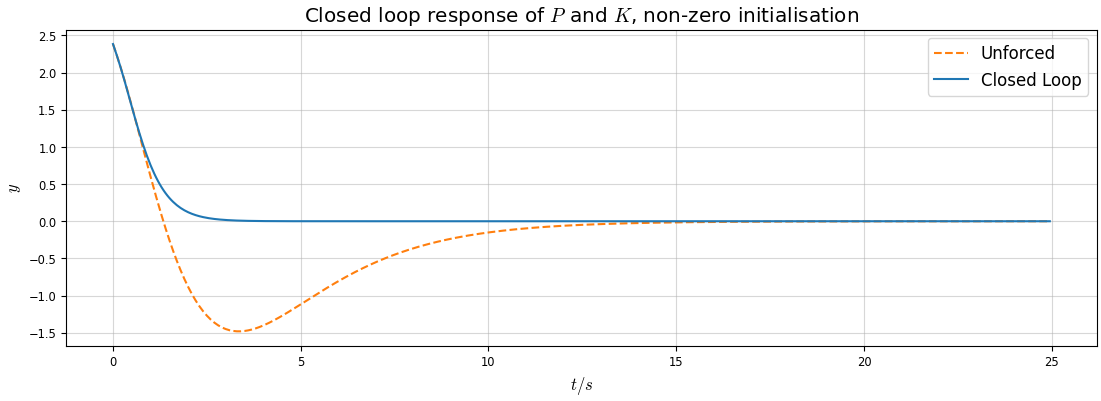

In [44]:
## Check controllability!
def isControlable(A, B):
    Wr = cm.ctrb(A, B)
    return lin.matrix_rank(Wr) == A.shape[0]

assert isControlable(P_reg.A, P_reg.B)==True, "System is uncontrollable D:"

CLpoles_reg = np.linspace(-2, -6, nx_reg)
K_reg = cm.place(P_reg.A, P_reg.B, CLpoles_reg)
CL_reg = cm.ss(P_reg.A-P_reg.B@K_reg, 
                np.zeros([nx_reg,1]), 
                P_reg.C, 
                P_reg.D)

forced_reg = cm.forced_response(sysdata=CL_reg, 
                                T=T_reg, 
                                X0=x0_reg)

####### Plotting #######
fig, ax = plt.subplots()
ax.plot(unforced_reg.time, unforced_reg.outputs, '--', color="tab:orange", label="Unforced")
ax.plot(forced_reg.time, forced_reg.outputs, color="tab:blue", label="Closed Loop")
ax.legend()
_ = ax.set(title="Closed loop response of $P$ and $K$, non-zero initialisation", xlabel="$t/s$", ylabel="$y$")


 However, regulating to zero is boring, I want to be able to tell my system to do a backflip! We need to add a reference, and I'll spoil that we also need a reference gain $k_f$:

 ![Reference tracking](refTrackCL.svg)

 So how does this work then... Same substitution as before!
 $$ \dot x = Ax + Bu = Ax + B(k_f r - Kx) = (A-BK) x + Bk_f r.$$
 Now to determine $k_f$, we want to prevent steady state errors, so $\bar y = r$. Steady state also means
 $$ \dot x = 0 = (A-BK) \bar x + Bk_f r \rightarrow \bar x = -(A-BK)^{-1}Bk_f r.$$
 Now assuming $D=0$ to make things easier, substituting and rewriting gives
 $$\bar y = r \rightarrow C\bar x + \underbrace{D}_{=0}\bar u = C\bar x = r$$
 $$\rightarrow -C(A-BK)^{-1}Bk_f r = r \rightarrow k_f = \frac{-1}{C(A-BK)^{-1}B}.$$


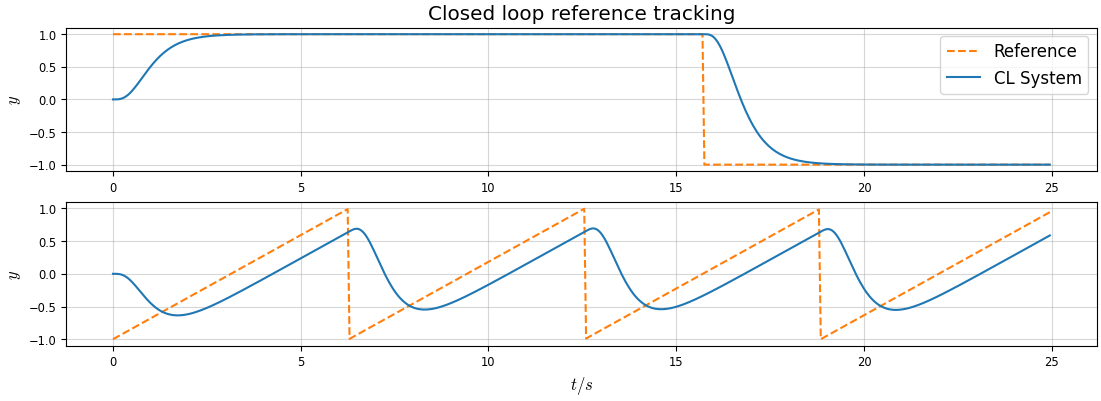

In [45]:
kf_ref = (-1/(P_reg.C@lin.inv(P_reg.A - P_reg.B@K_reg)@P_reg.B))[0,0]

CL_ref = cm.ss(P_reg.A-P_reg.B@K_reg, 
               P_reg.B*kf_ref, 
               P_reg.C, 
               P_reg.D)
sqr_ref = signal.square(t=T_reg*0.2)
saw_ref = signal.sawtooth(t=T_reg)

response_sqr_ref = cm.forced_response(sysdata=CL_ref, T=T_reg, U=sqr_ref)
response_saw_ref = cm.forced_response(sysdata=CL_ref, T=T_reg, U=saw_ref)

fig, ax = plt.subplots(2,1)
ax[0].plot(response_sqr_ref.time, response_sqr_ref.inputs , '--', color="tab:orange", label="Reference")
ax[0].plot(response_sqr_ref.time, response_sqr_ref.outputs, color="tab:blue", label="CL System")
ax[1].plot(response_saw_ref.time, response_saw_ref.inputs , '--', color="tab:orange", label="Reference")
ax[1].plot(response_saw_ref.time, response_saw_ref.outputs, color="tab:blue", label="CL System")
ax[0].legend()
_ = ax[0].set(title="Closed loop reference tracking", ylabel="$y$")
_ = ax[1].set(xlabel="$t/s$", ylabel="$y$")


 ## Integral action
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*The theory of everything is not found yet, so our model **always** sucks*

 Most likely the model we have is not a perfect representation of the real world. "Neglect air friction, neglect static/dynamic friction and hysteresis, assume rigid bodies, assume perfect efficiency, ..." All lies we tell ourselves to make our lives easier and to blind ourselves to the harsh reality.

 So if out model is incorrect, what does that mean for our controller? Simply said, it's not exactly what we want, but *it's close*. To get it perfect however, we need to add an output feedback part to our state feedback controller. An integrator of the reference-output-error to be precise. This integrator wil drive the integral of the error, $z$, to zero, meaning that the error will be zero. I'll stop talking now and show the block diagram so you actually understand.

 ![Integral action](IntActCL.svg)

 Sooooo maths time. Substitute everything into everything, yada yada, this is largely what control engineers do. Also assume D=0. Lets start with plant equations and work our way backwards through the block diagram.

 $$\left\{\begin{aligned}\dot x &= Ax + Bu = Ax + B(k_fr-Kx-k_iz) = (A-BK)x + Bk_fr-Bk_iz \\ y &= Cx\end{aligned}\right.$$
 and
 $$\dot z = y - r = Cx - r.$$
 Augmenting (stacking) the $x$ and $z$ dynamics gives the nice expression
 $$\left\{\begin{aligned}\begin{bmatrix}\dot x\\\dot z\end{bmatrix} &= \begin{bmatrix}
 (A-BK) & -Bk_i\\ C&0\end{bmatrix}\begin{bmatrix} x\\ z\end{bmatrix} + \begin{bmatrix}Bk_f\\-1\end{bmatrix}r \\ y &= \begin{bmatrix}C&0\end{bmatrix}\begin{bmatrix} x\\ z\end{bmatrix}.\end{aligned}\right.$$
 Saying $q = \begin{bmatrix} x\\ z\end{bmatrix}$ gives the new state space representation
 $$\left\{\begin{aligned}\dot q &= \begin{bmatrix}
 (A-BK) & -Bk_i\\ C&0\end{bmatrix}q + \begin{bmatrix}Bk_f\\-1\end{bmatrix}r \\ y &= \begin{bmatrix}C&0\end{bmatrix}q.\end{aligned}\right.$$

 Note that the integral error is independent from $A$, so however bad our modeling mistakes are, the integral action will fix it (as long as it's stable). First however, lets look at the nominal behaviour.

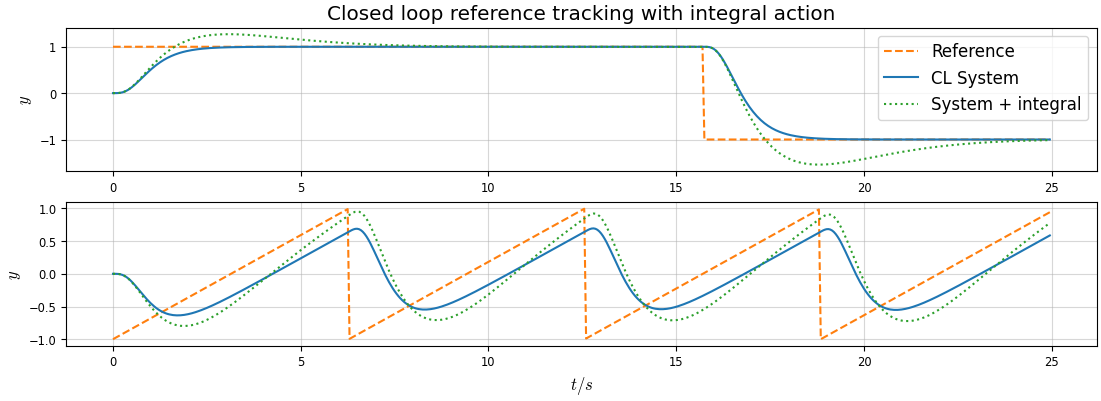

In [46]:
ki = 80. ## CHANGEME

CL_int = cm.ss(np.block([[P_reg.A-P_reg.B@K_reg, -P_reg.B*ki                     ],
                         [P_reg.C,           np.zeros_like(P_reg.C @ P_reg.B)]]), 
               np.vstack((P_reg.B*kf_ref, -1)), 
               np.hstack((P_reg.C, [[0]])), 
               np.zeros([1,1]))

response_sqr_int = cm.forced_response(sysdata=CL_int, T=T_reg, U=sqr_ref)
response_saw_int = cm.forced_response(sysdata=CL_int, T=T_reg, U=saw_ref)

fig, ax = plt.subplots(2,1)
ax[0].plot(response_sqr_ref.time, response_sqr_ref.inputs , '--', color="tab:orange", label="Reference")
ax[0].plot(response_sqr_ref.time, response_sqr_ref.outputs, color="tab:blue", label="CL System")
ax[0].plot(response_sqr_int.time, response_sqr_int.outputs, ':', color="tab:green", label="System + integral")
ax[1].plot(response_saw_ref.time, response_saw_ref.inputs , '--', color="tab:orange", label="Reference")
ax[1].plot(response_saw_ref.time, response_saw_ref.outputs, color="tab:blue", label="CL System")
ax[1].plot(response_saw_int.time, response_saw_int.outputs, ':', color="tab:green", label="System + integral")
ax[0].legend()
_ = ax[0].set(title="Closed loop reference tracking with integral action", ylabel="$y$")
_ = ax[1].set(xlabel="$t/s$", ylabel="$y$")

 And now we face dreadful reality and perturb our plant a little!

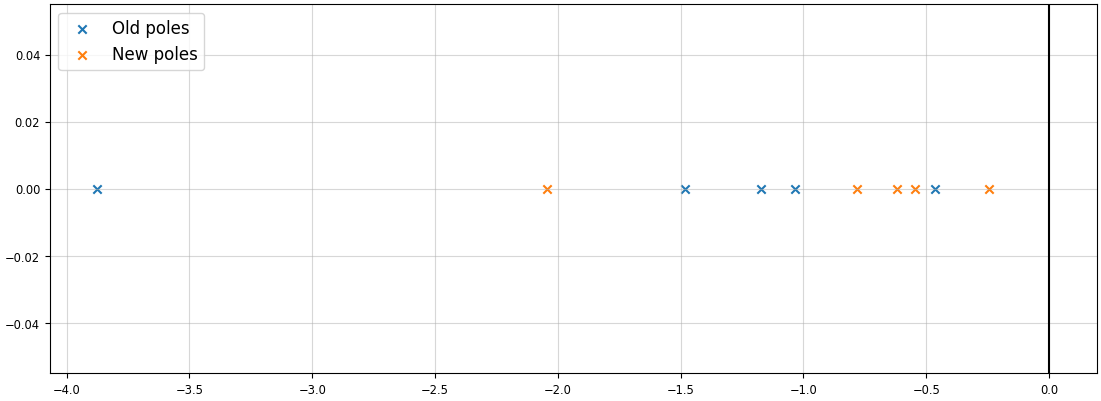

In [47]:
# See https://github.com/python-control/python-control/issues/1188 for the datatype nonsense
ran = np.abs(1. + rng.randn(2) * .3)
poles_pert = [(ran[0] * pole.real + ran[1] * pole.imag*1j).astype(np.complex64) 
                    for pole in P_reg.poles()]

P_pert = cm.ss(cm.zpk(zeros=P_reg.zeros().astype(np.complex64), 
                      poles=poles_pert, 
                      gain=1, dt=0))
P_pert.C *= rng.randn()*.2 + 1.


fig, ax = plt.subplots(1, 1)
ax.axvline(color='k')
s1 = ax.scatter(P_reg.poles().real, P_reg.poles().imag, marker='x', color='tab:blue', label="Old poles")
        
s2 = ax.scatter(P_pert.poles().real, P_pert.poles().imag, marker='x', color='tab:orange', label="New poles")
ax.legend(handles=[s1,s2])

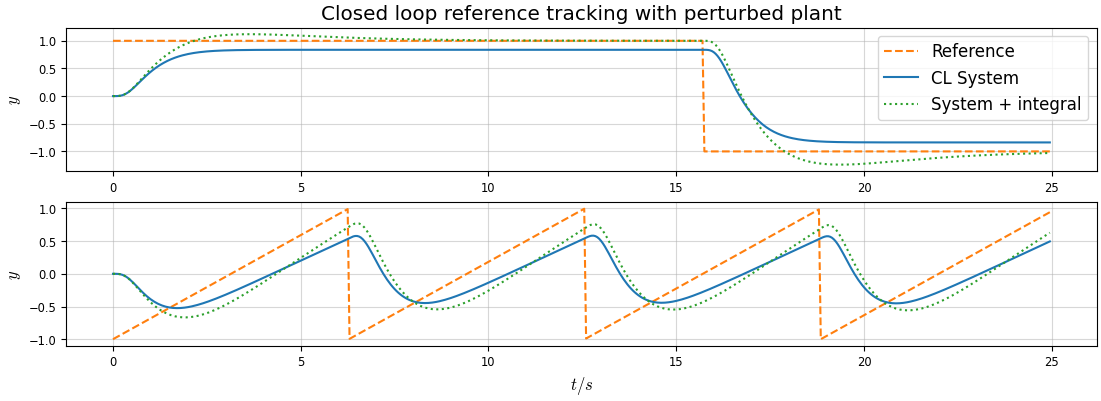

In [48]:
CL_pert = cm.ss(P_pert.A-P_pert.B@K_reg, 
               P_pert.B*kf_ref, 
               P_pert.C, 
               P_pert.D)
sqr_ref = signal.square(t=T_reg*0.2)
saw_ref = signal.sawtooth(t=T_reg)

response_sqr_ref_pert = cm.forced_response(sysdata=CL_pert, T=T_reg, U=sqr_ref)
response_saw_ref_pert = cm.forced_response(sysdata=CL_pert, T=T_reg, U=saw_ref)

CL_int_pert = cm.ss(np.block([[P_pert.A-P_pert.B@K_reg, -P_pert.B*ki                 ],
                              [P_pert.C,           np.zeros_like(P_pert.C @ P_pert.B)]]), 
               np.vstack((P_pert.B*kf_ref, -1)), 
               np.hstack((P_pert.C, [[0]])), 
               np.zeros([1,1]))

response_sqr_int_pert = cm.forced_response(sysdata=CL_int_pert, T=T_reg, U=sqr_ref)
response_saw_int_pert = cm.forced_response(sysdata=CL_int_pert, T=T_reg, U=saw_ref)

fig, ax = plt.subplots(2,1)
ax[0].plot(response_sqr_ref_pert.time, response_sqr_ref_pert.inputs , '--', color="tab:orange", label="Reference")
ax[0].plot(response_sqr_ref_pert.time, response_sqr_ref_pert.outputs, color="tab:blue", label="CL System")
ax[0].plot(response_sqr_int_pert.time, response_sqr_int_pert.outputs, ':', color="tab:green", label="System + integral")
ax[1].plot(response_saw_ref_pert.time, response_saw_ref_pert.inputs , '--', color="tab:orange", label="Reference")
ax[1].plot(response_saw_ref_pert.time, response_saw_ref_pert.outputs, color="tab:blue", label="CL System")
ax[1].plot(response_saw_int_pert.time, response_saw_int_pert.outputs, ':', color="tab:green", label="System + integral")
ax[0].legend()
_ = ax[0].set(title="Closed loop reference tracking with perturbed plant", ylabel="$y$")
_ = ax[1].set(xlabel="$t/s$", ylabel="$y$")

 See how bad the system without the integral action performs? (If not, randomise the plant again...)

 <div style="text-align:center;background-color:tomato;">End of lecture 6</div>

 ## Controller design is an art
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Art with maths is the best kind of art.*

 Okay, we know now what structure our controller will have. Time to design our controller! Since we do this by placing the poles of the closed loop systems via $K$, we'll look at what behaviour various poles show. Poles come in conjugate pairs, so for generality we'll look at the second-order ODE
 $$ \ddot q + 2\zeta\omega_0\dot q + \omega_0^2 = k\omega_0^2 u.$$
 Here, $\omega_0$ is called the natural frequency and $\zeta$ the damping ratio. Then, the characteristic polynomial is
 $$s^2 + 2\zeta\omega_0s + \omega_0^2,$$
 with roots/poles at $\lambda = -\zeta\omega_0\pm\omega_0\sqrt{\zeta^2-1}$. Time to play around again!

$\lambda_1 = -\zeta\omega_0+\omega_0\sqrt{\zeta^2-1} = -1.040+0.780j$

$|\lambda_1| = \omega_0 = 1.300$

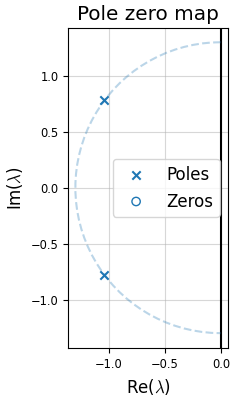

In [49]:
omega0 = 1.3    #CHANGEME
zeta = .8       #CHANGEME

s = cm.tf('s')
P_2d = 1/(s**2 + 2*zeta*omega0*s + omega0**2)

### Processing and Plotting ###

fig, ax = plt.subplots()
ax.axvline(color='k')
s1 = ax.scatter(np.real(P_2d.poles()), np.imag(P_2d.poles()), marker='x', color='tab:blue', label="Poles")
s2 = ax.scatter(np.real(P_2d.zeros()), np.imag(P_2d.zeros()), marker='o', facecolors='none', color='tab:blue', label="Zeros")
ax.plot(np.real(omega0*np.exp(np.linspace(0.5,1.5)*np.pi*1j)), np.imag(omega0*np.exp(np.linspace(0.5,1.5)*np.pi*1j)), '--', alpha=.3)
ax.set(title="Pole zero map", xlabel="Re($\lambda$)", ylabel="Im($\lambda$)", aspect='equal')
ax.legend(handles=[s1, s2])

display(Markdown(rf'$\lambda_1 = -\zeta\omega_0+\omega_0\sqrt{"{"}\zeta^2-1{"}"} = {-zeta*omega0 + omega0*np.emath.sqrt(zeta**2-1):.3f}$'))
display(Markdown(rf'$|\lambda_1| = \omega_0 = {np.abs(P_2d.poles()[0]):.3f}$'))

 Now lets look at the step responses! We have three (or four) terms for intervals of $\zeta$:
 1. $\zeta>1$ is overdamped
 2. $\zeta=1$ is critically damped
 3. $\zeta\in [0,1]$ is underdamped
 4. and $\zeta<1$ is unstable.

 Also the speed of the response is defined by $\omega_0$. We'll plot a few of these.

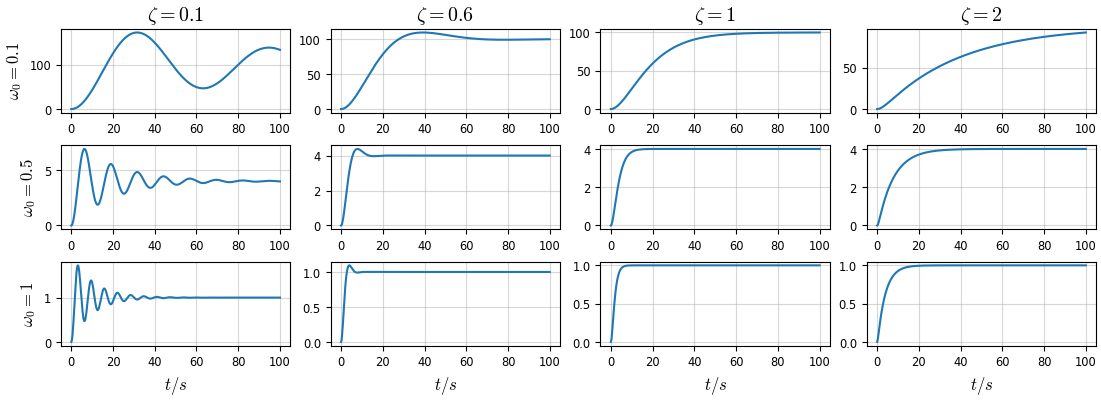

In [50]:
# You can put in whatever and any number of values you want
Omega0 = [.1, .5, 1]
Zeta = [0.1, 0.6, 1, 2]

### Processing and Plotting ###
fig, ax = plt.subplots(len(Omega0), len(Zeta))
T = np.linspace(0, 100, 500)

for omega0, axIdx1 in zip(Omega0, range(len(Omega0))):
    for zeta, axIdx2 in zip(Zeta, range(len(Zeta))):
        Pq = cm.ss(1/(s**2 + 2*zeta*omega0*s + omega0**2), dt=0)
        response = cm.forced_response(Pq, T=T, U=np.ones_like(T))
        ax[axIdx1, axIdx2].plot(response.time, response.outputs)

[ax[0,p].set(title=f"$\zeta={Zeta[p]}$") for p in range(len(Zeta))]
[ax[p,0].set(ylabel=f"$\omega_0={Omega0[p]}$") for p in range(len(Omega0))]
_ = [ax[2,p].set(xlabel=f"$t/s$") for p in range(len(Zeta))]

 ### Why are second order systems so important?
 It turns out that system behaviour is largely dictated by the dominant eigenvalue pair (equivalently, the slowest pair, the pair with the largest real value). If there are pole pairs with the same real value, the pair with the lowest damping ratio $\zeta = -\frac{\mathfrak{R}(\lambda)}{|\lambda|}$ is the dominant pair.


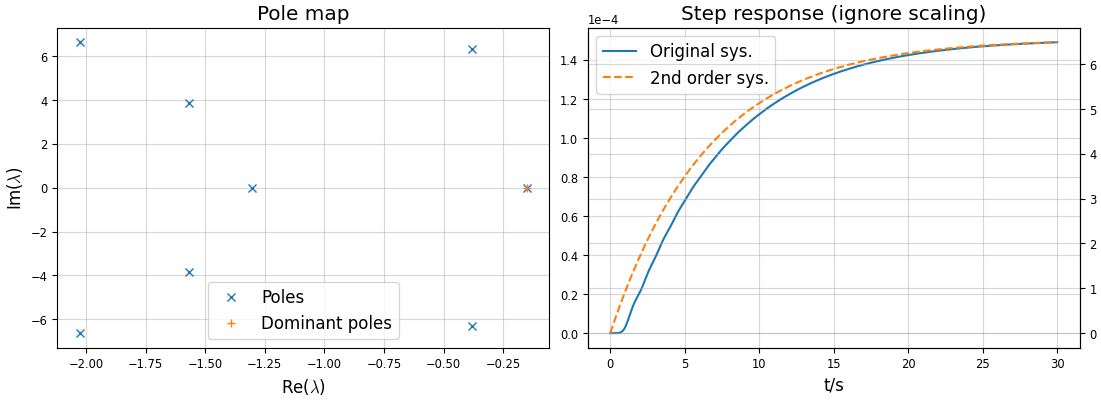

In [51]:
P_dom = cm.rss(8)
P_dom = cm.ss(cm.zpk(poles=P_dom.poles(), zeros=[], gain=1, dt=0))

# Find dominant poles
poles = P_dom.poles()
DomRe = poles.real.max()
DomPoles = poles[np.abs(np.real(poles) / DomRe -1) < 1e-4]

if len(DomPoles) > 2:
    dampRatio = -np.real(DomPoles)/np.abs(DomPoles)
    DomPoles2d = DomPoles[dampRatio == min(dampRatio)]
else:
    DomPoles2d = DomPoles

P_dom_2d = cm.ss(cm.zpk(poles=DomPoles2d, zeros=[], gain=1, dt=0))

T_dom = np.linspace(0, 30, 500)
response_dom =    cm.forced_response(P_dom,    T=T_dom, U=np.ones_like(T_dom))
response_dom_2d = cm.forced_response(P_dom_2d, T=T_dom, U=np.ones_like(T_dom))

fig, ax = plt.subplots(1, 2)
ax[0].plot(P_dom.poles().real, P_dom.poles().imag, 'x', color='tab:blue', label="Poles")
ax[0].plot(P_dom_2d.poles().real, P_dom_2d.poles().imag, '+', color='tab:orange', label="Dominant poles")
ax[0].set(title="Pole map", xlabel="Re($\lambda$)", ylabel="Im($\lambda$)")
ax[0].legend()


l0 = ax[1].plot(response_dom.time, response_dom.outputs, color="tab:blue", label="Original sys.")
l1 = ax[1].twinx().plot(response_dom_2d.time, response_dom_2d.outputs, '--', color="tab:orange", label="2nd order sys.")
ax[1].legend(handles = [l0[0], l1[0]])
_ = ax[1].set(title="Step response (ignore scaling)", xlabel="t/s")#, yticks=[])

 ## Art is for suckers and should be optimised
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*If you believe AI artists are artist, you're wrong, but you'll like this part.*

 Linear Quadratic Regulators (LQR) have a special place in my heart. Instead of having a (in some sense) heuristic $K$, smarter people than me came up with the idea of expressing $K$ as the solution to an optimisation problem to obtain *optimal control*. So what optimisation is this? The trick is to balance the control input action and the state deviation, so that calls for the input optimisation $$\min_u \int_0^\infty x^\intercal (t) Q_x x(t) + u^\intercal(t) Q_u u(t) dt.$$

 The $Q$ matrices here are semi-positive weighing matrices, the higher the weight, the more penalised the signal.

 The solution to this equation is not easy, but it's found by finding symmetric $S\in\mathbb{R}^{n\times n}, S>0$ such that
 $$A^\intercal S + SA - SBQ^{-1}_uB^\intercal S + Q_x = 0,$$
 which is called the Algebraic Riccati Equation (ARE). Then with this $S$ we can find $K=Q^{-1}_uB^\intercal S$. Also $u=-Kx$, as a reminder. Lets see if you can beat the optimal control!

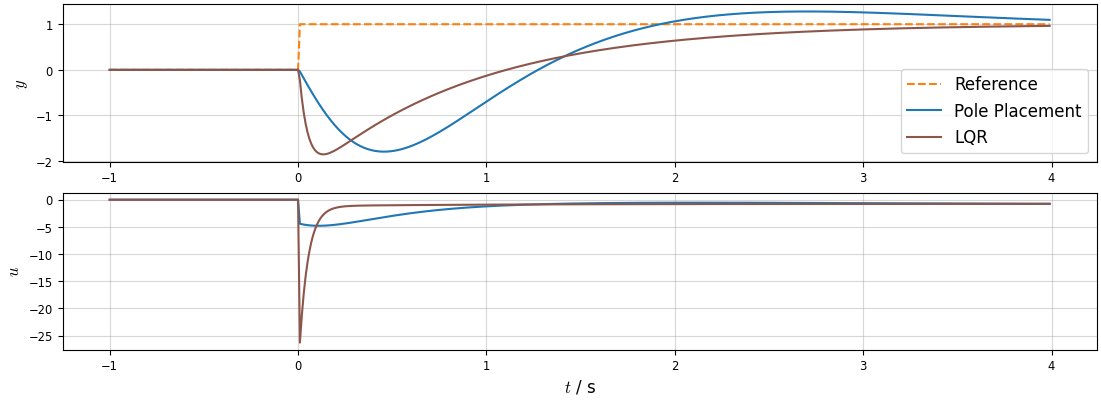

In [52]:
P_lqr = cm.rss(4, strictly_proper=True)
nx_lqr = len(P_lqr.poles())
x0_lqr = rng.randn(nx_lqr,1)

T_lqr = np.arange(500)*0.01 - 1.
step_lqr = np.zeros_like(T_lqr)
step_lqr[T_lqr > 0.] = 1.

assert isControlable(P_lqr.A, P_lqr.B)==True, "System is uncontrollable D:"

## Pole Placement
CLpoles_pp = [-1+1j, -1-1j, -4-2j, -4+2j] ### CHANGEME

K_pp = cm.place(P_lqr.A, P_lqr.B, CLpoles_pp)
kf_pp = (-1/(P_lqr.C@lin.inv(P_lqr.A - P_lqr.B@K_pp)@P_lqr.B))[0,0]
CL_pp = cm.ss(P_lqr.A-P_lqr.B@K_pp, 
              P_lqr.B*kf_pp, 
              P_lqr.C, 
              P_lqr.D)
response_pp = cm.forced_response(sysdata=CL_pp, 
                                 T=T_lqr, 
                                 U=step_lqr)

## LQR
Qx, Qu = np.eye(nx_lqr)*1e2, np.eye(1)*1 ### CHANGEME

K_lqr, _, _ = cm.lqr(P_lqr.A, P_lqr.B, Qx, Qu) 
kf_lqr = (-1/(P_lqr.C@lin.inv(P_lqr.A - P_lqr.B@K_lqr)@P_lqr.B))[0,0]
CL_lqr = cm.ss(P_lqr.A-P_lqr.B@K_lqr, 
               P_lqr.B*kf_lqr, 
               P_lqr.C, 
               P_lqr.D)
response_lqr = cm.forced_response(sysdata=CL_lqr, 
                                  T=T_lqr, 
                                  U=step_lqr)

fig, ax = plt.subplots(2,1)
ax[0].plot(response_pp.time, response_pp.inputs, '--', color="tab:orange", label="Reference")
ax[0].plot(response_pp.time, response_pp.outputs, color="tab:blue", label="Pole Placement")
ax[0].plot(response_lqr.time, response_lqr.outputs, color="tab:brown", label="LQR")
ax[0].legend()
ax[0].set(ylabel="$y$")

ax[1].plot(response_pp.time , (-K_pp  @ response_pp.states)[0,:]  + kf_pp*response_pp.inputs, color="tab:blue", label="Pole Placement")
ax[1].plot(response_lqr.time, (-K_lqr @ response_lqr.states)[0,:] + kf_lqr*response_lqr.inputs, color="tab:brown", label="LQR")
_=ax[1].set(ylabel="$u$", xlabel="$t$ / s")

 <div style="text-align:center;background-color:tomato;">End of lecture 7</div>

 ## Observe this
 Reality is here to ruin our day again. Practically, we never know/measure the full state, so $u=-Kx$ doesn't really work, because we don't know $x$. That means everything that we've done up to now only exists in the realms of mathematics. But our trickery is endless! We'll say that we have an **estimate** of the state, $\hat x$. We'll also say that we have an estimation error $\tilde x = x - \hat x$. Lastly, we make a *Luenberger observer*, $L$, that's implemented as
 $$\dot{\hat x} = A\hat x + B u + L(y − C \hat x).$$
 Now it's that time again, our favourite time, substitution time!
 $$\dot{\hat x} = A\hat x + B u + L(y − C \hat x) = A\hat x + B u + LC(x − \hat x) = A\hat x + B u + LC\tilde x$$
 $$\Rightarrow \dot x - \dot{\hat x} = \dot{\tilde x} = Ax + Bu - A\hat x - B u - LC\tilde x = A(x − \hat x) - LC\tilde x = A\tilde x - LC\tilde x = (A-LC)\tilde x.$$

 Wait, that's familiar! That looks a whole lot like controller pole placement! That is because there is a duality between Luenberger observers and state feedback controllers, practically anything you can do for controllers/controlability with the pair $(A,B)$, you can do for observers/observability with the pair $(A^\intercal, C^\intercal)$.

 Looking at that last equation written above,
 $$\dot{\tilde x} = (A-LC)\tilde x,$$
 it is very reminiscent of the state feedback controllers that were expressed earlier as
 $$ \dot x = (A-BK) x.$$
 Taking the transpose of the error dynamics equations reveals the true duality between $L$ and $K$:
 $$\dot{\tilde x}^\intercal = \tilde x^\intercal (A^\intercal-C^\intercal L^\intercal).$$
 Here you see that pair $(A^\intercal, C^\intercal)$ appear. If we design $L^\intercal$ such that the error dynamics are asymptotically stable, then the error goes to zero asymptotically. That means that we quickly get a good estimate of the state that we can use for state feedback control.

 So we have
 | Control   | Observe   |
 | --------- | --------- |
 | $K = \texttt{cm.place}(A, B, p)$      | $L.T = \texttt{cm.place}(A.T, C.T, p)$       |
 | $W_r = \begin{bmatrix}B & AB & \cdots & A^{n-1}B\end{bmatrix}$ | $W_o^\intercal = \begin{bmatrix}C^\intercal & (CA)^\intercal & \cdots & (CA^{n-1})^\intercal\end{bmatrix}$ |


 This *observability matrix*, $W_o$, is the dual twin of the controlability matrix. If it has full rank, the system is *observable*.

 So what does this do in practise? Lets make some observers! One trick we need to program this though is the augmentation of the state space with the estimate dynamics, i.e.
 $$\begin{bmatrix}\dot x \\ \dot{\hat x} \end{bmatrix} = \begin{bmatrix}A&0\\ LC & A - LC\end{bmatrix}\begin{bmatrix} x \\ \hat x \end{bmatrix} + \begin{bmatrix}B \\ B \end{bmatrix} u$$
 $$y = \begin{bmatrix}C & 0 \end{bmatrix}\begin{bmatrix} x \\ \hat x \end{bmatrix}.$$


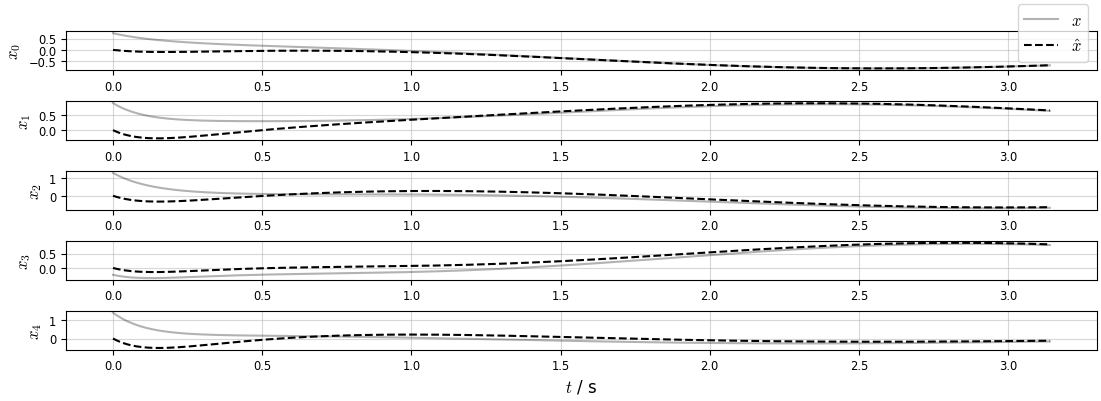

In [62]:
P_obs = cm.rss(5, strictly_proper=True)
nx = len(P_obs.poles())
x0 = rng.randn(nx,1)

T_obs = np.arange(500)*0.01

## Check observability!
def isObservable(A, C):
    Wo = cm.obsv(A, C)
    return lin.matrix_rank(Wo) == A.shape[0]

assert isObservable(P_obs.A, P_obs.C)==True, "System is unobservable D:"

obsv_poles = np.linspace(-1., -3, nx)
L = cm.place(P_obs.A.transpose(), P_obs.C.transpose(), obsv_poles).transpose()

P_obs_aug = cm.ss(np.block([[P_obs.A,      np.zeros_like(P_obs.A)], # A
                        [L@P_obs.C,    P_obs.A - L@P_obs.C]]),
              np.vstack((P_obs.B, P_obs.B)), # B
              np.hstack((P_obs.C, np.zeros_like(P_obs.C))), # C
              [[0]]) # D


obsIn = np.sin(T_obs)**1.7
response_obs = cm.forced_response(P_obs_aug, 
                                 T=T_obs, 
                                 U=obsIn, 
                                 X0=np.vstack((rng.randn(nx,1), np.zeros([nx,1])))) # Nonzero initialisation!

fig, ax = plt.subplots(nx, 1)
for idx in range(nx-1):
    ax[idx].plot(response_obs.time, response_obs.states[idx, :], 'k', alpha=.3)
    ax[idx].plot(response_obs.time, response_obs.states[idx+nx, :], 'k--')
    ax[idx].set_ylabel(f"$x_{idx}$")

ax[0].legend(handles=[
    ax[nx-1].plot(response_obs.time, response_obs.states[nx-1, :], 'k', alpha=.3, label=r"$x$")[0],
    ax[nx-1].plot(response_obs.time, response_obs.states[nx-1+nx, :], 'k--', label=r"$\hat x$")[0]
    ])
_ = ax[nx-1].set(ylabel = f"$x_{nx-1}$", xlabel = "$t$ / s")

 ### Quicker than thou
 So if you run the previous cell a few times, you'll see that the performance of the observer can vary wildly. Why is that? Well it depends on how fast the system is in comparison to the observer: if the system dynamics are faster than the observer, the state will change faster than the error can go to zero, resulting in poor estimates. Lets see what that looks like in a more structured way:

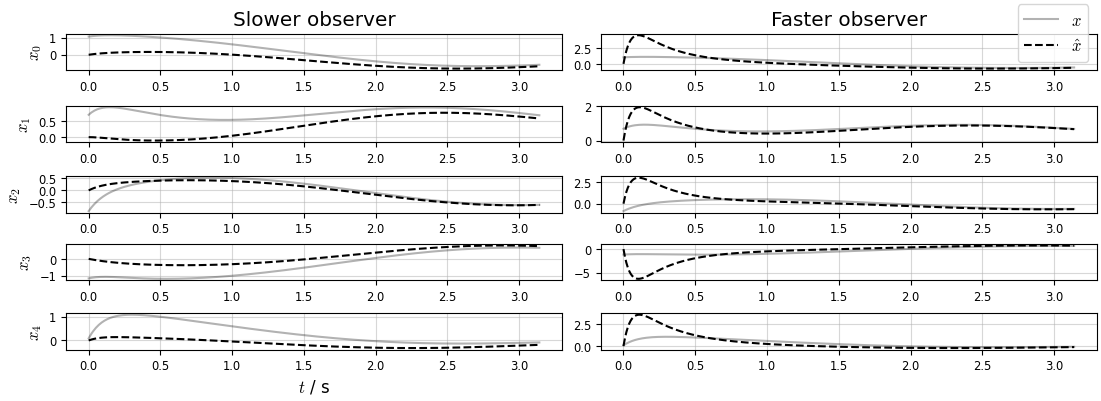

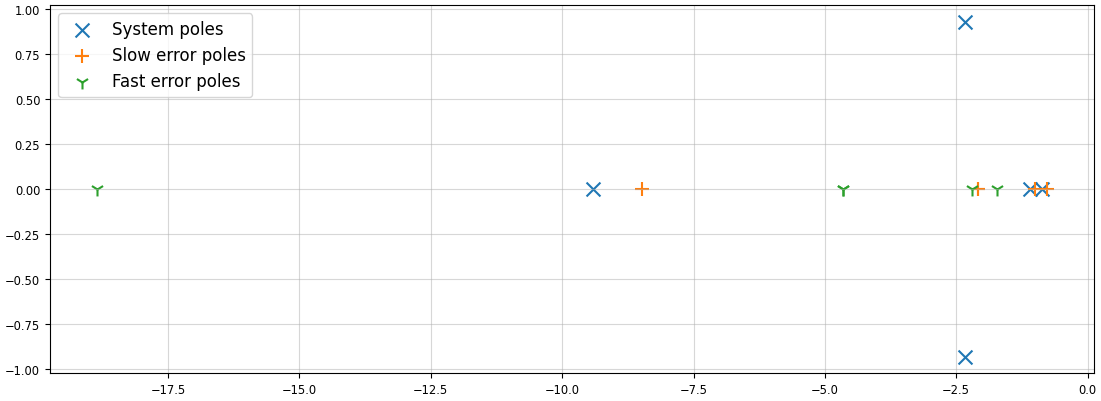

In [64]:
obsv_poles_slow = P_obs.poles().real * .9 + P_obs.poles().imag * 1e-5
obsv_poles_fast = P_obs.poles().real * 2. + P_obs.poles().imag * 1e-5
L_slow = cm.place(P_obs.A.transpose(), P_obs.C.transpose(), obsv_poles_slow).transpose()
L_fast = cm.place(P_obs.A.transpose(), P_obs.C.transpose(), obsv_poles_fast).transpose()

P_obs_aug_slow = cm.ss(np.block([[P_obs.A,      np.zeros_like(P_obs.A)], # A
                                 [L_slow@P_obs.C,    P_obs.A - L_slow@P_obs.C]]),
                            np.vstack((P_obs.B, P_obs.B)), # B
                            np.hstack((P_obs.C, np.zeros_like(P_obs.C))), # C
                            [[0]]) # D

P_obs_aug_fast = cm.ss(np.block([[P_obs.A,      np.zeros_like(P_obs.A)], # A
                                 [L_fast@P_obs.C,    P_obs.A - L_fast@P_obs.C]]),
                            np.vstack((P_obs.B, P_obs.B)), # B
                            np.hstack((P_obs.C, np.zeros_like(P_obs.C))), # C
                            [[0]]) # D

X0 = np.vstack((rng.randn(nx,1), np.zeros([nx,1]))) # Nonzero initialisation!
response_obs_slow = cm.forced_response(P_obs_aug_slow, 
                                        T=T_obs, 
                                        U=obsIn, 
                                        X0=X0) 
response_obs_fast = cm.forced_response(P_obs_aug_fast, 
                                        T=T_obs, 
                                        U=obsIn, 
                                        X0=X0) 

fig, ax = plt.subplots(nx, 2)
for idx in range(nx-1):
    ax[idx, 0].plot(response_obs_slow.time, response_obs_slow.states[idx, :], 'k', alpha=.3)
    ax[idx, 0].plot(response_obs_slow.time, response_obs_slow.states[idx+nx, :], 'k--')
    ax[idx, 1].plot(response_obs_fast.time, response_obs_fast.states[idx, :], 'k', alpha=.3)
    ax[idx, 1].plot(response_obs_fast.time, response_obs_fast.states[idx+nx, :], 'k--')
    ax[idx, 0].set_ylabel(f"$x_{idx}$")

ax[0, 1].legend(handles=[
    ax[nx-1,0].plot(response_obs_slow.time, response_obs_slow.states[nx-1, :], 'k', alpha=.3, label=r"$x$")[0],
    ax[nx-1,0].plot(response_obs_slow.time, response_obs_slow.states[nx-1+nx, :], 'k--', label=r"$\hat x$")[0]
    ])
ax[nx-1,1].plot(response_obs_fast.time, response_obs_fast.states[nx-1, :], 'k', alpha=.3, label=r"$x$")[0]
ax[nx-1,1].plot(response_obs_fast.time, response_obs_fast.states[nx-1+nx, :], 'k--', label=r"$\hat x$")[0]
_ = ax[nx-1,0].set(ylabel = f"$x_{nx-1}$", xlabel = "$t$ / s")

ax[0,0].set_title("Slower observer")
ax[0,1].set_title("Faster observer")

e_slow = lin.eigvals(P_obs.A - L_slow @ P_obs.C)
e_fast = lin.eigvals(P_obs.A - L_fast @ P_obs.C)

fig, ax = plt.subplots()
_ = ax.legend(handles= [
    ax.scatter(P_obs.poles().real, P_obs.poles().imag, s=100, marker='x', color='tab:blue', label="System poles"),
    ax.scatter(e_slow.real, e_slow.imag, s=100, marker='+', color='tab:orange', label="Slow error poles"),
    ax.scatter(e_fast.real, e_fast.imag, s=100, marker='1', color='tab:green', label="Fast error poles"),
])

 ## Connecting the dots

 Time to make the full picture: state feedback control with state estimation! Some important things to note:
 - Since the state feedback is based on the state estimation, we want the error to go to zero faster than the controller works. If the controller is faster than the observer you're just doing random stuff basically until the estimate converges. Rule of thumb: the observer should be 4 to 10 times faster (larger magnitude poles) than the controller.
 - Making the observer extremely fast works well in theory, but as soon as your output is noisy, the fast observer will amplify this noise enourmously and your estimate will be terrible.
 - In the example below I'll make an LQR observer, but since the observer is a regulator type controller, no feedforward gain is needed.
 - Strictly speaking you can classify this as output feedback

 Please also take a look at the code for how to use the control toolbox more effectively.

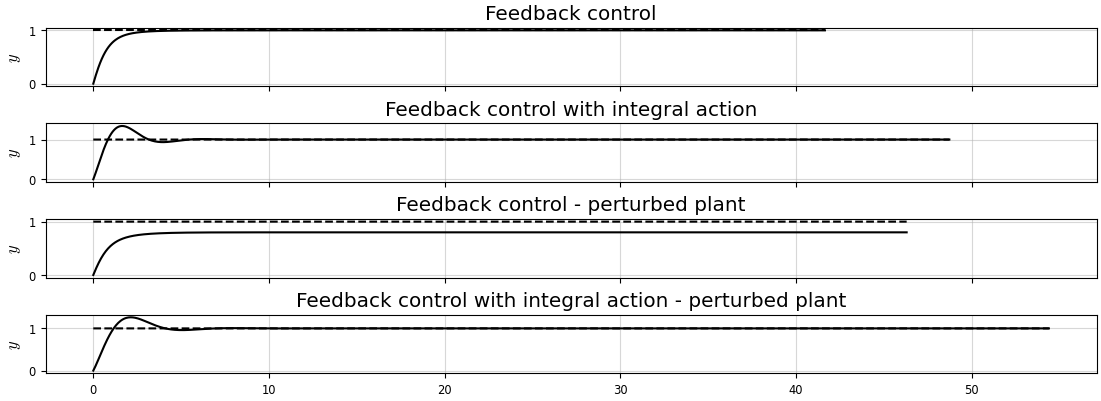

In [68]:
P_all = cm.rss(5, inputs='u_tot', outputs='y', name='P', strictly_proper=True)
nx_all = P_all.A.shape[0]
x0_all = rng.randn(nx_all,1)

## Integral action (negative for coding reasons (flipped sumblock later))
ki_all = -1.

## LQR state 
assert isControlable(P_all.A, P_all.B)==True, "System is uncontrollable D:"

Qx_K, Qu_K = np.eye(nx_all)*1e0, np.eye(1)*1e0
K_all, _, _ = cm.lqr(P_all.A, P_all.B, Qx_K, Qu_K) 
kf_all = (-1/(P_all.C@lin.inv(P_all.A - P_all.B@K_all)@P_all.B))[0,0]

## Observer
assert isObservable(P_all.A, P_all.C)==True, "System is unobservable D:"

Qx_obs, Qu_obs = np.eye(nx_all)*1e3, np.eye(1)*1e0 # Note the much higher penalty on state esimation error
L_all, _, _ = cm.lqr(P_all.A.transpose(), P_all.C.transpose(), Qx_obs, Qu_obs)
L_all = L_all.transpose()
obs_all = cm.ss(P_all.A - L_all @ P_all.C,
                np.hstack((P_all.B, L_all)),
                np.eye(nx_all),
                np.zeros([nx_all,2]),
                inputs = ["u_tot", "y"], 
                # outputs = ['x_est'], # it doesn't understand ):
                name="Observer")

## Also create perturbed system
ran = np.abs(1. + rng.randn(2) * .1)
poles_all_pert = [(ran[0] * pole.real + ran[1] * pole.imag*1j).astype(np.complex64) 
                  for pole in P_all.poles()]

P_all_pert = cm.ss(cm.zpk(zeros=P_all.zeros().astype(np.complex64), 
                        poles=poles_all_pert, 
                        gain=1, dt=0), 
                    inputs='u_tot', outputs='y', name='P')
P_all_pert.C *= rng.randn()*.2 + 1.

## Build blocks and subsystems
u_sumblk = cm.summing_junction(
    inputs = ["u_ctrl", "u_rff", "u_int"],
    output = "u_tot",
    name = "u_sumblk"
)
r_sumblk = cm.summing_junction(
    inputs = ["y", "ref"],
    output = ["ref_err"],
    name = "r_sumblk"
)
integral_action = cm.ss(-ki_all/s, 
                        inputs = "ref_err",
                        output = "u_int",
                        name = "integral_action")
Kctrl = cm.ss([[0]], np.zeros_like(K_all), [[0]], -K_all, 
                # inputs = "x_est", # it doesn't understand ):
                output = "u_ctrl",
                name = "Kctrl")
FBctrl = cm.series(obs_all, Kctrl,
                    inputs = ['u_tot', 'y'],
                    outputs = "u_ctrl",
                    name = "FBctrl")
rFFgain = cm.ss([[0]], [[0]], [[0]], [[kf_all]], 
                inputs = "ref",
                output = "u_rff",
                name = "rFFgain")

## Build systems: with and without integral action and for a perturbed system
CL_FBctrl = cm.interconnect(syslist = [P_all, FBctrl, rFFgain, u_sumblk],
                            connections = [
                                ['P', 'u_sumblk.u_tot'],
                                ['FBctrl.y', 'P'],
                                ['FBctrl.u_tot', 'u_sumblk.u_tot'],
                                ['u_sumblk.u_rff', 'rFFgain'],
                                ['u_sumblk.u_ctrl', 'FBctrl']
                                ],
                            inputs = 'ref',
                            outputs = 'y')
CL_FBctrl_int = cm.interconnect(syslist = [P_all, FBctrl, rFFgain, u_sumblk, integral_action, r_sumblk],
                                connections = [
                                    ['P', 'u_sumblk.u_tot'],
                                    ['FBctrl.y', 'P'],
                                    ['FBctrl.u_tot', 'u_sumblk.u_tot'],
                                    ['u_sumblk.u_rff', 'rFFgain'],
                                    ['u_sumblk.u_ctrl', 'FBctrl'],
                                    ['integral_action', 'r_sumblk'],
                                    ['r_sumblk.y', '-P.y'],
                                    ['u_sumblk.u_int', 'integral_action']
                                    ],
                                inputs = 'ref',
                                outputs = 'y')
CL_FBctrl_pert = cm.interconnect(syslist = [P_all_pert, FBctrl, rFFgain, u_sumblk],
                                connections = [
                                    ['P', 'u_sumblk.u_tot'],
                                    ['FBctrl.y', 'P'],
                                    ['FBctrl.u_tot', 'u_sumblk.u_tot'],
                                    ['u_sumblk.u_rff', 'rFFgain'],
                                    ['u_sumblk.u_ctrl', 'FBctrl']
                                    ],
                                inputs = 'ref',
                                outputs = 'y')
CL_FBctrl_int_pert = cm.interconnect(syslist = [P_all_pert, FBctrl, rFFgain, u_sumblk, integral_action, r_sumblk],
                                connections = [
                                    ['P', 'u_sumblk.u_tot'],
                                    ['FBctrl.y', 'P'],
                                    ['FBctrl.u_tot', 'u_sumblk.u_tot'],
                                    ['u_sumblk.u_rff', 'rFFgain'],
                                    ['u_sumblk.u_ctrl', 'FBctrl'],
                                    ['integral_action', 'r_sumblk'],
                                    ['r_sumblk.y', '-P.y'],
                                    ['u_sumblk.u_int', 'integral_action']
                                    ],
                                inputs = 'ref',
                                outputs = 'y')

## Look at step response
fig, ax = plt.subplots(4, 1, sharex=True)
for sys, idx, title in zip([CL_FBctrl, CL_FBctrl_int, CL_FBctrl_pert, CL_FBctrl_int_pert], range(4),
                           ["Feedback control", "Feedback control with integral action",
                            "Feedback control - perturbed plant", "Feedback control with integral action - perturbed plant"]):
    response = cm.step_response(sys)
    ax[idx].plot(response.time, response.inputs, 'k--')
    ax[idx].plot(response.time, response.outputs, 'k')
    ax[idx].set(ylabel="$y$", title=title)

 Run the previous cell a few times... fun fact: there is no generic fix for control problems...

 <div style="text-align:center;background-color:tomato;">End of lecture 8</div>